In [1]:
library(lattice)
library(MASS)
require(pscl) # alternatively can use package ZIM for zero-inflated models
library(lmtest)
library(marginaleffects)
library(ggcorrplot)
library(performance)
library(see)
library(topmodels)
library(statmod)
library(assessor)

Loading required package: pscl

Classes and Methods for R originally developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University (2002-2015),
by and under the direction of Simon Jackman.
hurdle and zeroinfl functions by Achim Zeileis.



Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: ggplot2



In [2]:
formula <- UMIs_mBC ~ cell_type_annotation + rep_id + CRE_id | rep_id
formula_nonzi <- UMIs_mBC ~ cell_type_annotation + rep_id + CRE_id

formula_cell_type_nonzi <- UMIs_mBC ~ rep_id + CRE_id 
formula_cell_type <- UMIs_mBC ~ rep_id + CRE_id | rep_id



In [3]:
data <- read.csv("shendure_counts_grouped.txt", sep='\t', header = T)
data_cardio <- read.csv("shendure_counts_grouped_cardio.txt", sep='\t', header = T)

Check for zero-inflation

In [4]:
100*sum(data$UMIs_mBC == 0)/nrow(data)

[1] 85.75236

Over 85% of the data are zeros, we may need a zero inflated model, but we'll build up in order of complexity

# Initial Model training

## Poisson GLM

In [5]:
# M1 <- glm(formula_nonzi,
#           family = 'poisson',
#           data = data)
#saveRDS(M1, file = "poisson_rep_id_CRE_id.RDS")
pm <- readRDS("poisson_rep_id_CRE_id.RDS")
summary(M1)

ERROR: Error: object 'M1' not found


In [ ]:

## Check for over/underdispersion in the model
E2 <- resid(M1, type = "pearson")
N  <- nrow(data)
p  <- length(coef(M1))   
sum(E2^2) / (N - p)

[1] 39.78493

In [7]:
model_performance(M1)

AIC     AICc    BIC     R2_Nagelkerke RMSE     Sigma Score_log
1 8349348 8349348 8351962 1             42.66164 1     -Inf     
  Score_spherical
1 0.001025918

In [11]:
a <- check_model(M1, show_dots = F)

In [8]:
check_overdispersion(M1)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =       39.785
  Pearson's Chi-Squared = 30953551.557
                p-value =      < 0.001


Using `ci_type = "gaussian"` because model is not bernoulli.



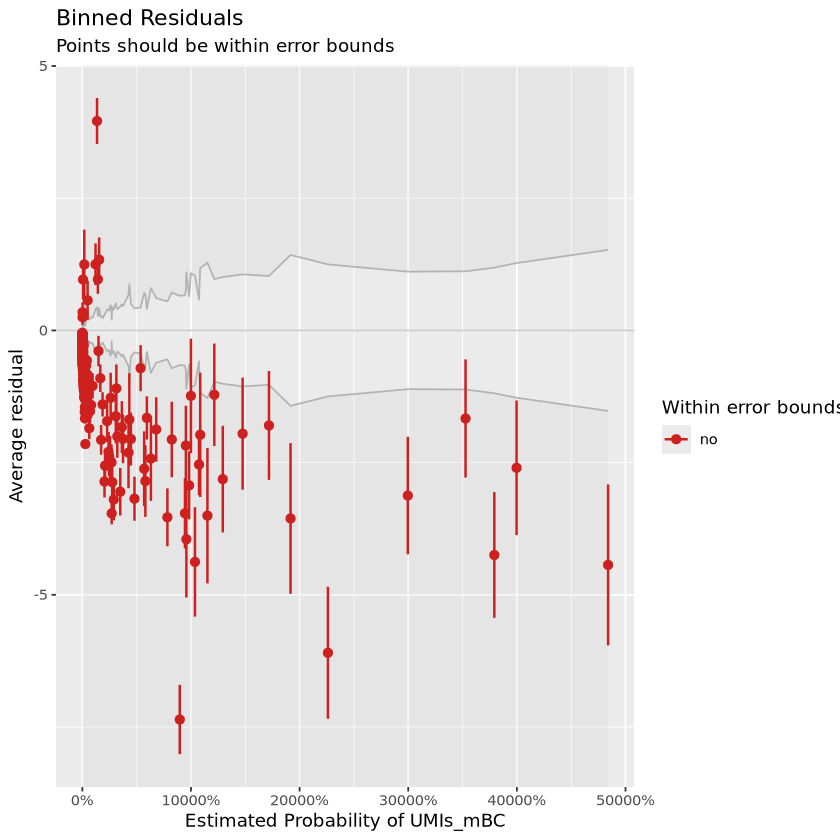

In [8]:
bin_res <- binned_residuals(M1)
plot(bin_res)

Variable `Component` is not in your data frame :/



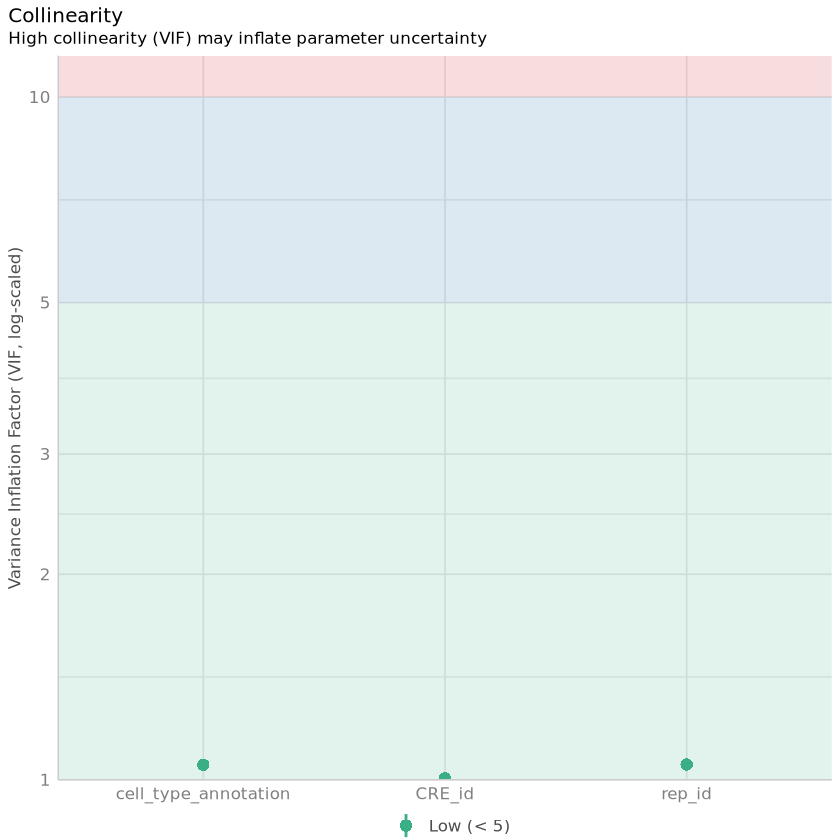

In [9]:
collin <- check_collinearity(M1)
plot(collin)

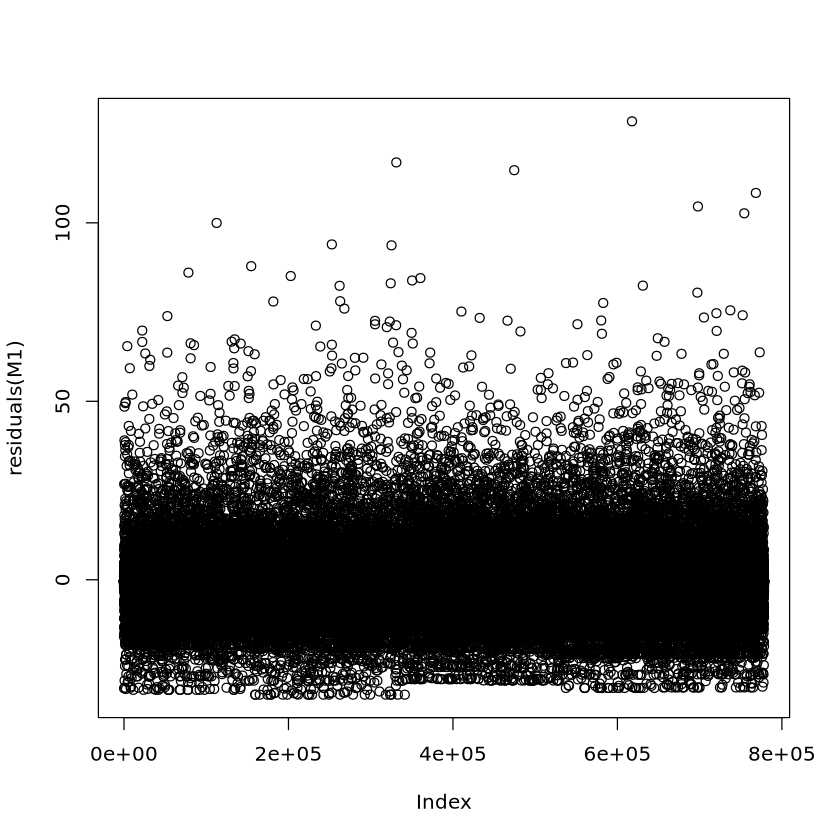

In [22]:
plot(residuals(M1))

There's no formal statistical test for normality for generalized linear
  model.
  Instead, please use `simulate_residuals()` and `check_residuals()` to
  check for uniformity of residuals.



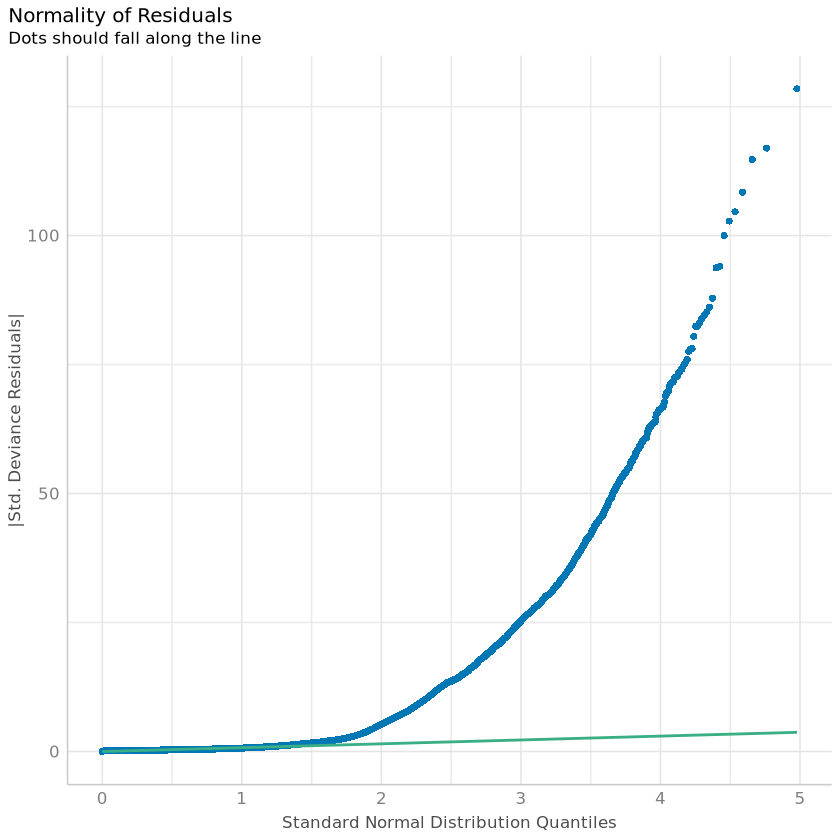

In [20]:
norm_res <- check_normality(M1)
plot(norm_res, type="density")

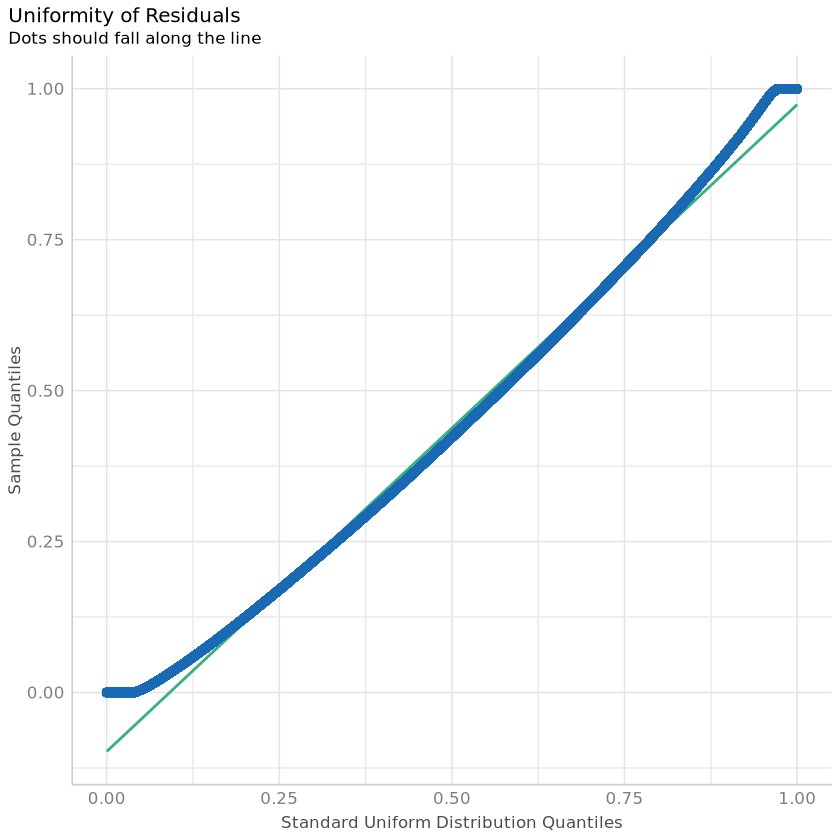

In [18]:
norm_res <- simulate_residuals(M1)
plot(norm_res, type="qq")

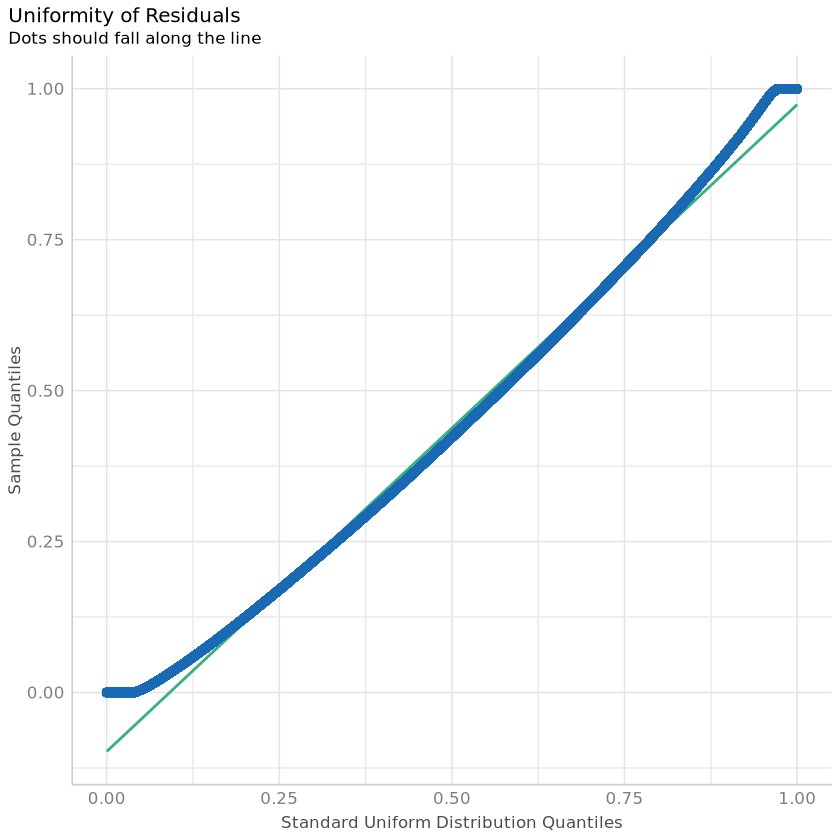

In [19]:
norm_res <- check_residuals(M1)
plot(norm_res, type="qq")

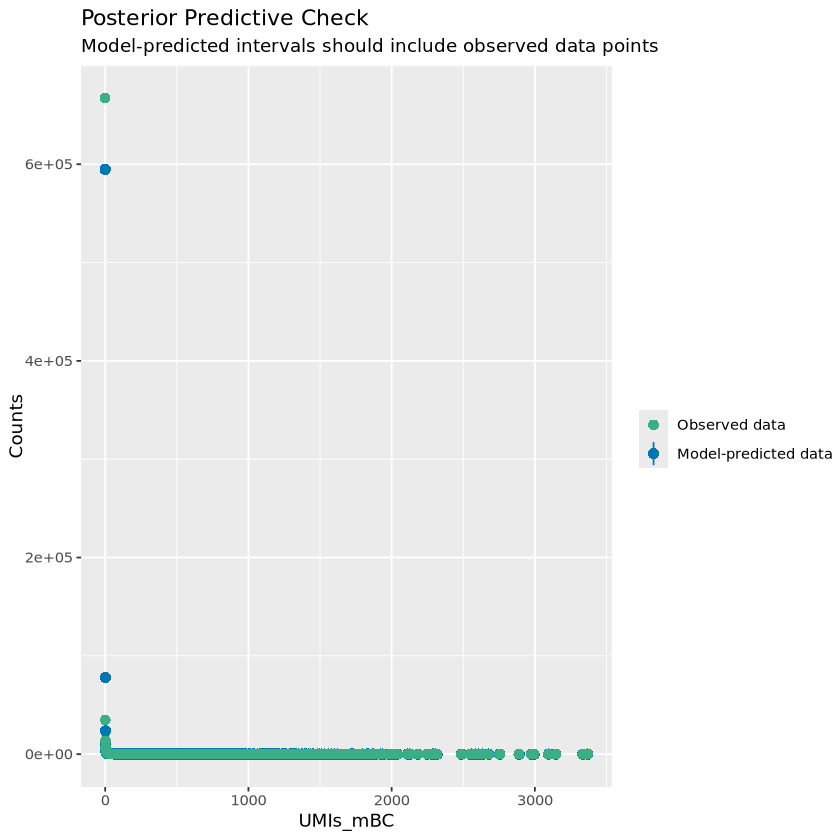

In [10]:
pred <- check_predictions(M1)
plot(pred)

In [11]:
check_model(M1)

## Negative Binomial GLM

In [68]:
# M2 <- glm.nb(formula_nonzi,
#              data = data)

# summary(M2)
# saveRDS(M2, file = "negbin_rep_id_CRE_id.RDS")

nb <- readRDS("negbin_rep_id_CRE_id.RDS")

In [16]:
summary(M2)


Call:
glm.nb(formula = formula_nonzi, data = data, init.theta = 0.2373467146, 
    link = log)

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                   -4.027e+00  1.347e-01 -29.891
cell_type_annotationEpiblast/primitive streak  6.070e-01  3.403e-02  17.838
cell_type_annotationEx. Endoderm (parietal)    1.066e+00  3.340e-02  31.912
cell_type_annotationEx. Endoderm (visceral)   -2.300e-02  3.527e-02  -0.652
cell_type_annotationHaematoendothelial         5.611e-02  3.944e-02   1.423
cell_type_annotationMesoderm                  -5.066e-01  3.355e-02 -15.099
cell_type_annotationNeuroectoderm (brain)     -4.531e-01  3.346e-02 -13.541
cell_type_annotationNeuroectoderm (rostral)   -4.679e-01  3.875e-02 -12.073
cell_type_annotationPluripotent                8.878e-01  3.261e-02  27.227
cell_type_annotationSurface Ectoderm          -7.978e-01  3.470e-02 -22.991
rep_id2B2                                     -5.416e

In [17]:
model_performance(M2)

AIC     AICc    BIC     R2_Nagelkerke RMSE     Sigma Score_log
1 1121379 1121379 1124004 0.9083281     49.65456 1     -Inf     
  Score_spherical
1 0.001029712

In [10]:
# Dispersion statistic
E2 <- resid(M2, type = "pearson")
N  <- nrow(data)
p  <- length(coef(M2)) + 1  # '+1' is for variance parameter in NB
sum(E2^2) / (N - p)

[1] 3.905747

In [11]:
check_overdispersion(M2)

Underdispersion detected.



# Overdispersion test

 dispersion ratio =   0.291
          p-value = < 0.001


In [24]:
check_model(M2, residual_type = "pearson")

The variance-covariance matrix is not positive definite. Returning the
  nearest positive definite matrix now.
  This ensures that eigenvalues are all positive real numbers, and
  thereby, for instance, it is possible to calculate standard errors for
  all relevant parameters.



## Zero-Inflated Poisson GLM

These models don't seem to like the full complexity of the CRE IDs, that seems like an important thing to include but maybe we could get away with total number of CREs tested being encoded as a constant somehow?

In [69]:
# M3 <- zeroinfl(formula,
#                dist = 'poisson',
#                data = data)

# summary(M3)

#saveRDS(M3, file = "zip_rep_id_CRE_id_rep_id.RDS")

zip <- readRDS("zip_rep_id_CRE_id_rep_id.RDS")

In [13]:
# Dispersion statistic
E2 <- resid(M3, type = "pearson")
N  <- nrow(data)
p  <- length(coef(M3))  
sum(E2^2) / (N - p)

[1] 7.827763

In [18]:
model_performance(M3)

AIC     AICc    BIC     R2        R2_adjusted RMSE    Sigma    Score_log
1 6832148 6832148 6834831 0.9697754 0.9697666   47.1302 47.13722 -Inf     
  Score_spherical
1 0.001045348

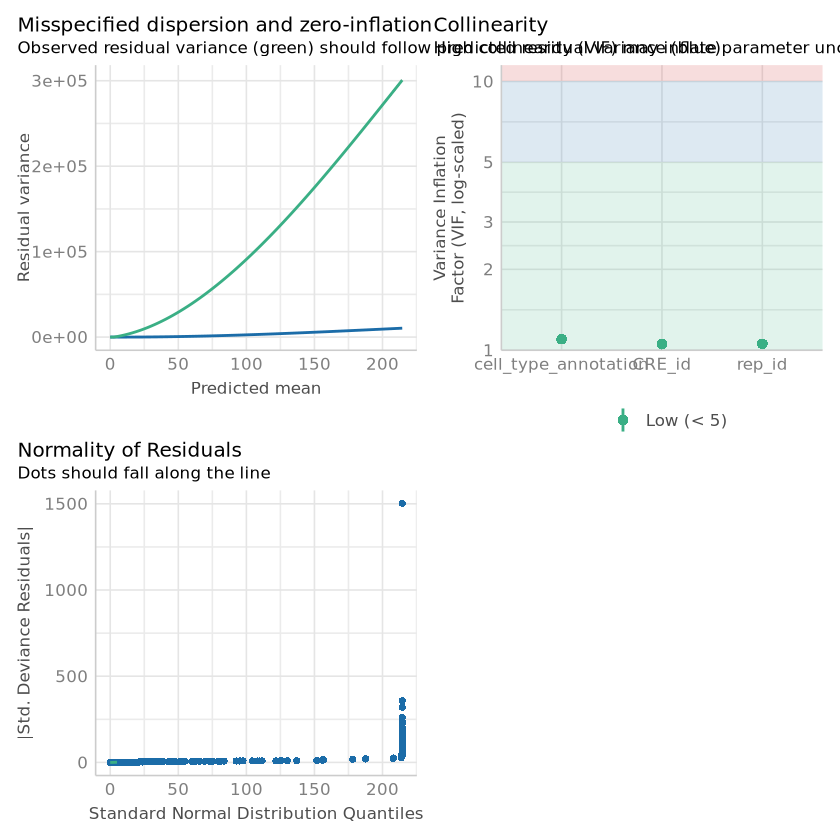

In [19]:
check_model(M3, residual_type = "pearson")

## Zero-Inflated Negative Binomial GLM

### Cardiomyocytes

In [5]:
pm <- glm(UMIs_mBC ~ rep_id + CRE_id ,
          family = 'poisson',
          data = data_cardio)

nb <- glm.nb(UMIs_mBC ~ rep_id + CRE_id ,
             data = data_cardio)

zip <-  zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'poisson',
               data = data_cardio)

zinb <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio)

In [6]:
zinb_logit <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, link='logit')





In [7]:

zinb_probit <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, link='probit')



Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.09935e-16FALSE”


In [8]:
zinb_cloglog <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, link='cloglog')



In [9]:
zinb_cauchit <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, link='cauchit')


In [10]:

zinb_nm <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, method = 'Nelder-Mead', maxit = 100000)

Warning message in zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id, dist = "negbin", :
“optimization failed to converge”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.10258e-27FALSE”


In [11]:
zinb_bfgs <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, method = 'BFGS', maxit = 10000)

In [12]:
zinb_cg <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, method = 'CG', maxit = 10000)

Warning message in zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id, dist = "negbin", :
“optimization failed to converge”


In [14]:
zinb_lbfgsb <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, method = 'L-BFGS-B', maxit = 10000)

Warning message in optim(fn = countloglikfun, gr = countgradfun, par = c(lmstart, :
“method L-BFGS-B uses 'factr' (and 'pgtol') instead of 'reltol' and 'abstol'”


Warning message in optim(fn = loglikfun, gr = gradfun, par = c(start$count, start$zero, :
“method L-BFGS-B uses 'factr' (and 'pgtol') instead of 'reltol' and 'abstol'”


In [15]:
zinb_sann <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, method = 'SANN', maxit = 10000)

In [16]:
zinb_brent <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, method = 'Brent', maxit = 10000)

ERROR: Error in log(start$theta): non-numeric argument to mathematical function


In [ ]:
links <- c('logit','cloglog','cauchit')

In [13]:
?optim

optim                  package:stats                   R Documentation

_G_e_n_e_r_a_l-_p_u_r_p_o_s_e _O_p_t_i_m_i_z_a_t_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     General-purpose optimization based on Nelder-Mead, quasi-Newton
     and conjugate-gradient algorithms. It includes an option for
     box-constrained optimization and simulated annealing.

_U_s_a_g_e:

     optim(par, fn, gr = NULL, ...,
           method = c("Nelder-Mead", "BFGS", "CG", "L-BFGS-B", "SANN",
                      "Brent"),
           lower = -Inf, upper = Inf,
           control = list(), hessian = FALSE)
     
     optimHess(par, fn, gr = NULL, ..., control = list())
     
_A_r_g_u_m_e_n_t_s:

     par: Initial values for the parameters to be optimized over.

      fn: A function to be minimized (or maximized), with first
          argument the vector of parameters over which minimization is
          to take place.  It should return a scalar result.

      gr: A

In [37]:



r2_zeroinflated(zinb)

# R2 for Zero-Inflated and Hurdle Regression
       R2: 0.998
  adj. R2: 0.998

In [40]:
r2(zip)

# R2 for Zero-Inflated and Hurdle Regression
       R2: 0.994
  adj. R2: 0.994

In [41]:
r2(nb)

# R2 for Generalized Linear Regression
  Nagelkerke's R2: 0.954

In [42]:
r2(pm)

# R2 for Generalized Linear Regression
  Nagelkerke's R2: 1.000

In [ ]:
check_model(pm)

In [49]:
check_model(nb)

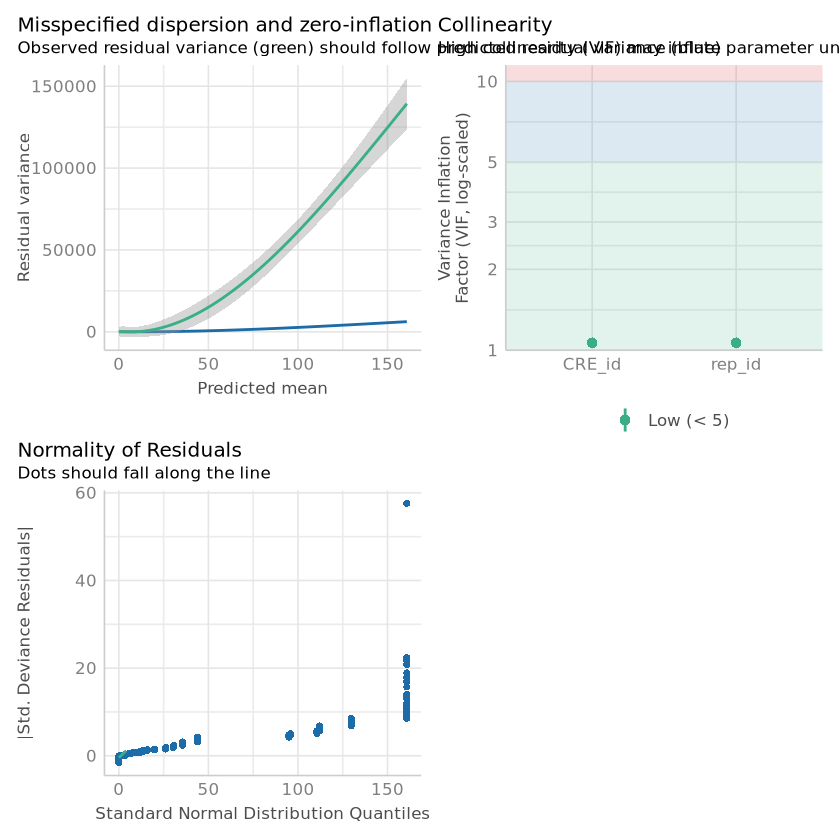

In [48]:
check_model(zip, residual_type = "normal")

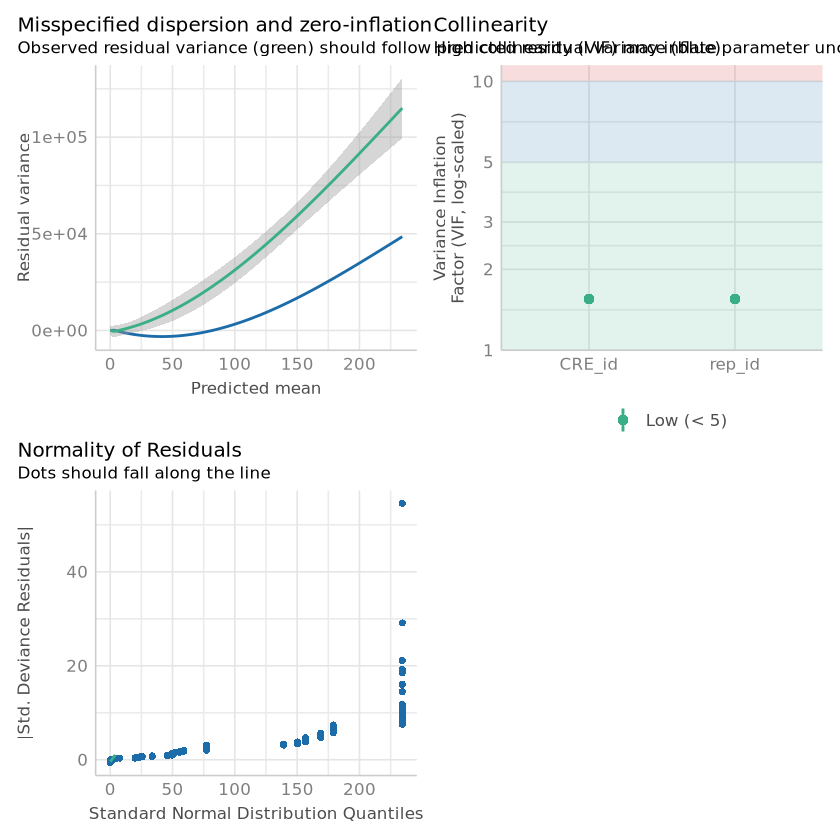

In [45]:
check_model(zinb, residual_type = "normal")

In [17]:
fitted(zinb, type='response')

1            2            3            4            5            6 
1.286815e+00 6.586196e-08 7.879398e-08 8.287921e-08 2.613597e-01 1.319309e-01 
           7            8            9           10           11           12 
4.896633e-02 7.276162e-08 3.563117e-02 1.582175e-02 8.752489e-02 3.345833e-01 
          13           14           15           16           17           18 
7.756021e-03 7.305858e-08 7.673733e-08 2.601372e-02 2.746965e-02 6.425879e-02 
          19           20           21           22           23           24 
5.768461e-02 7.136808e-02 1.091307e+00 1.555106e-02 7.093484e-02 1.727212e-01 
          25           26           27           28           29           30 
1.259564e-02 1.841276e-02 1.815907e+00 6.693759e-01 5.119320e-02 3.164963e-01 
          31           32           33           34           35           36 
4.582304e+01 1.998994e+01 6.975778e-08 2.613597e-01 6.762541e-08 5.544864e-01 
          37           38           39           40           41           42 
8.896055e-02 7.276162e-08 1.137181e+00 7.417935e-08 3.563117e-02 5.499214e-01 
          43           44           45           46           47           48 
7.093110e-08 7.840231e-08 6.550253e-02 7.876047e-08 1.347412e-01 1.570769e-01 
          49           50           51           52           53           54 
4.564481e+00 6.905297e-08 1.446328e-02 3.345833e-01 7.575171e-02 5.460628e-02 
          55           56           57           58           59           60 
7.673733e-08 2.601372e-02 1.888156e-02 2.746965e-02 1.727212e-01 7.397333e-08 
          61           62           63           64           65           66 
1.237340e+00 6.425879e-02 6.923618e-08 1.259564e-02 7.655865e-08 2.548581e-02 
          67           68           69           70           71           72 
2.239644e-02 1.841276e-02 1.611015e-01 9.575999e-03 3.668754e-02 1.563384e-01 
          73           74           75           76           77           78 
7.500122e-01 1.159071e-02 1.815907e+00 6.693759e-01 1.172876e+00 7.302697e-02 
          79           80           81           82           83           84 
5.119320e-02 3.164963e-01 1.091307e+00 1.555106e-02 1.391121e+02 2.899551e-02 
          85           86           87           88           89           90 
7.093484e-02 4.582304e+01 1.998994e+01 5.363309e-02 1.286815e+00 8.512774e-03 
          91           92           93           94           95           96 
2.613597e-01 8.659822e-02 7.207640e-08 4.115633e-01 7.646351e-08 7.717936e-08 
          97           98           99          100          101          102 
7.276162e-08 6.329189e-02 6.550253e-02 4.859601e-02 4.512548e-01 7.494175e-08 
         103          104          105          106          107          108 
1.607698e-01 2.069649e-01 1.446328e-02 5.116837e-02 3.345833e-01 2.162315e-02 
         109          110          111          112          113          114 
5.364723e-01 6.861501e-08 2.885843e-01 1.727212e-01 3.860601e-02 6.425879e-02 
         115          116          117          118          119          120 
5.157880e-02 2.239644e-02 1.563384e-01 6.931857e-08 1.172876e+00 9.876312e-02 
         121          122          123          124          125          126 
6.569602e-08 1.091307e+00 1.391121e+02 2.899551e-02 7.093484e-02 4.582304e+01 
         127          128          129          130          131          132 
1.998994e+01 7.207640e-08 7.717936e-08 1.359900e-01 1.926413e-01 8.860941e-02 
         133          134          135          136          137          138 
2.746965e-02 1.563384e-01 1.159071e-02 7.374036e-08 4.582304e+01 1.002974e-02 
         139          140          141          142          143          144 
8.512774e-03 2.613597e-01 1.461172e-01 7.207640e-08 4.798526e-01 7.717936e-08 
         145          146          147          148          149          150 
3.563117e-02 1.121102e-02 1.126641e+00 6.905297e-08 8.752489e-02 3.345833e-01 
         151          152          153          154          

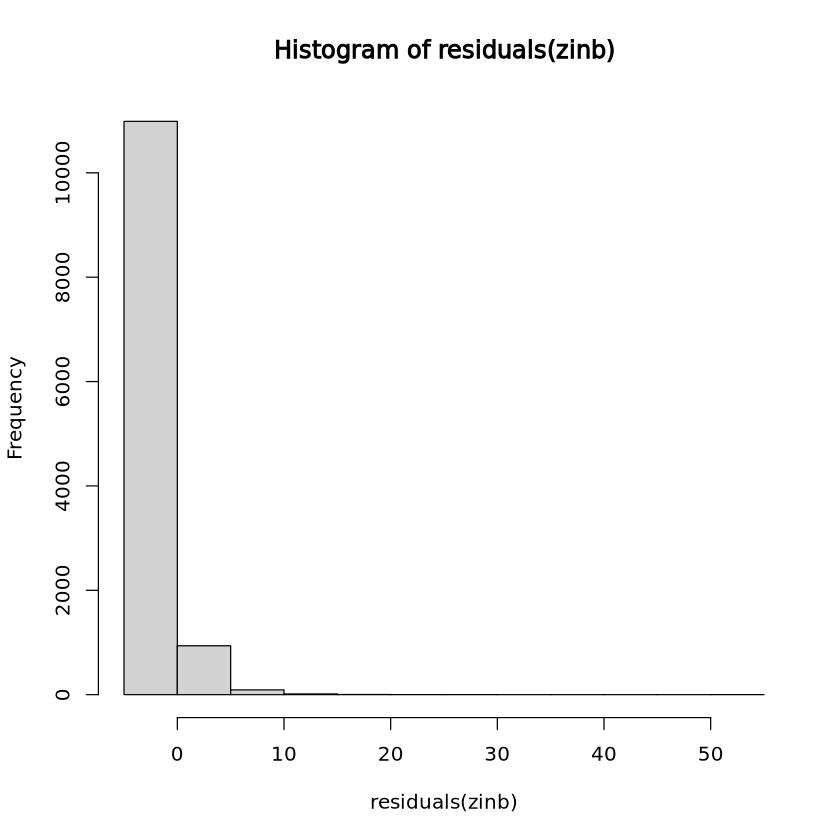

In [6]:
hist(residuals(zinb))

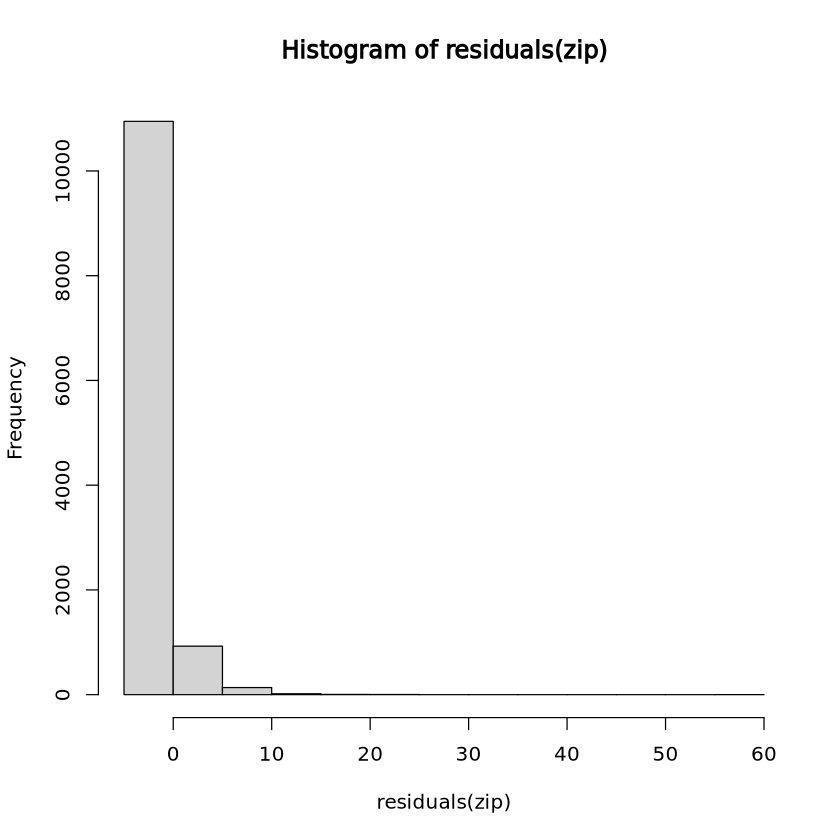

In [51]:
hist(residuals(zip))

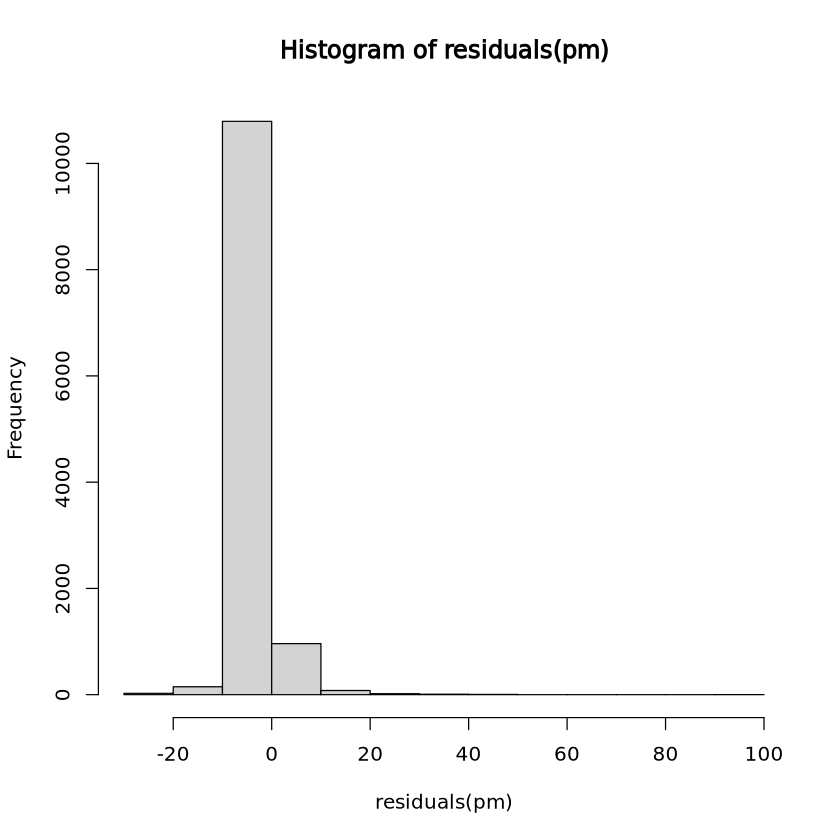

In [52]:
hist(residuals(pm))

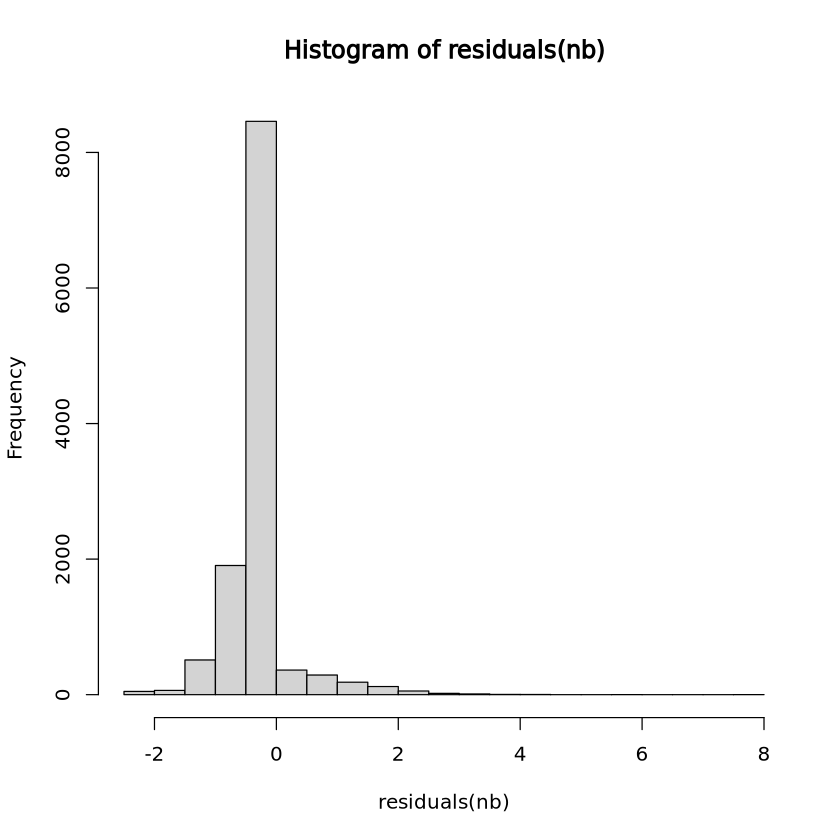

In [53]:
hist(residuals(nb))

In [ ]:
# Dispersion Statistic
E2 <- resid(M4, type = "pearson")
N  <- nrow(data_cardio)
p  <- length(coef(M4)) + 1 # '+1' is due to theta
sum(E2^2) / (N - p)

[1] 1.299172

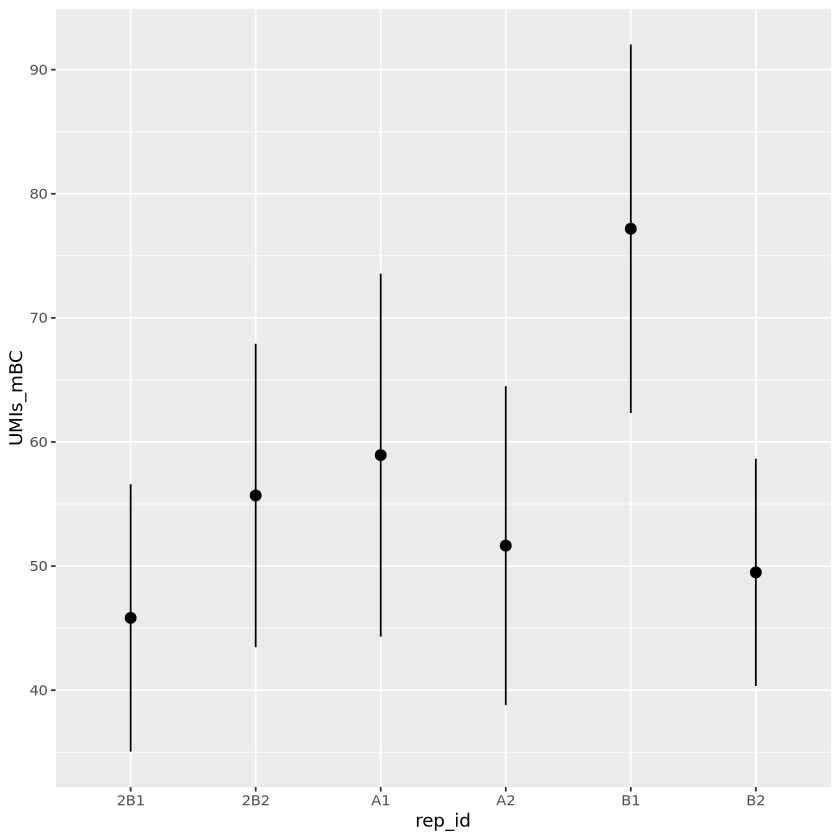

In [ ]:
plot_predictions(M4, condition='rep_id')

In [8]:
plot_predictions(M4, condition='CRE_id')

ERROR: Error: object 'M4' not found


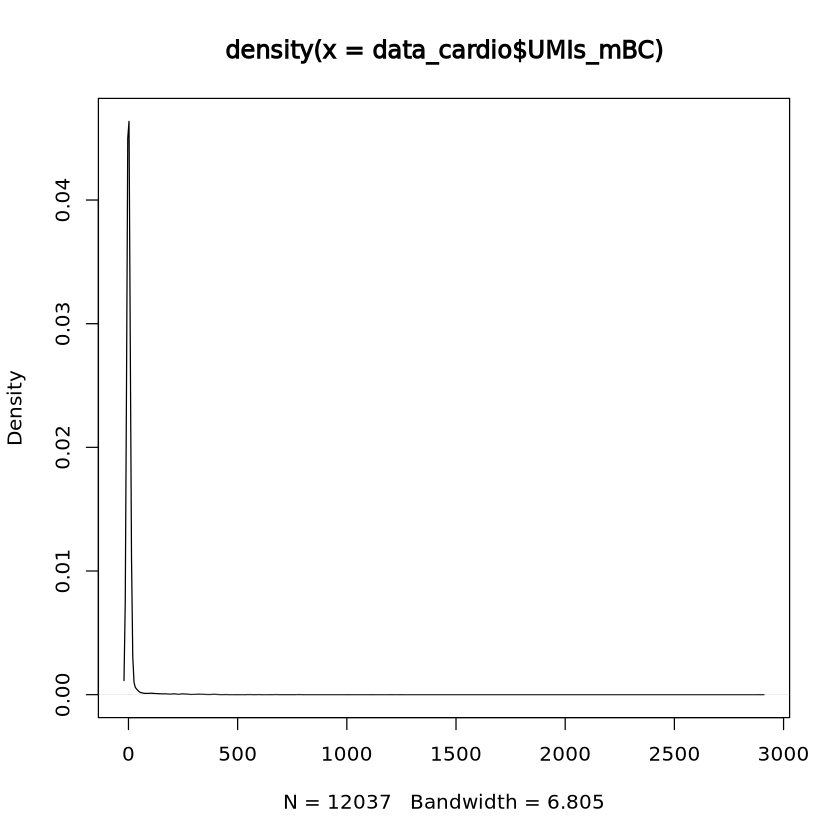

In [9]:
plot(density(data_cardio$UMIs_mBC))

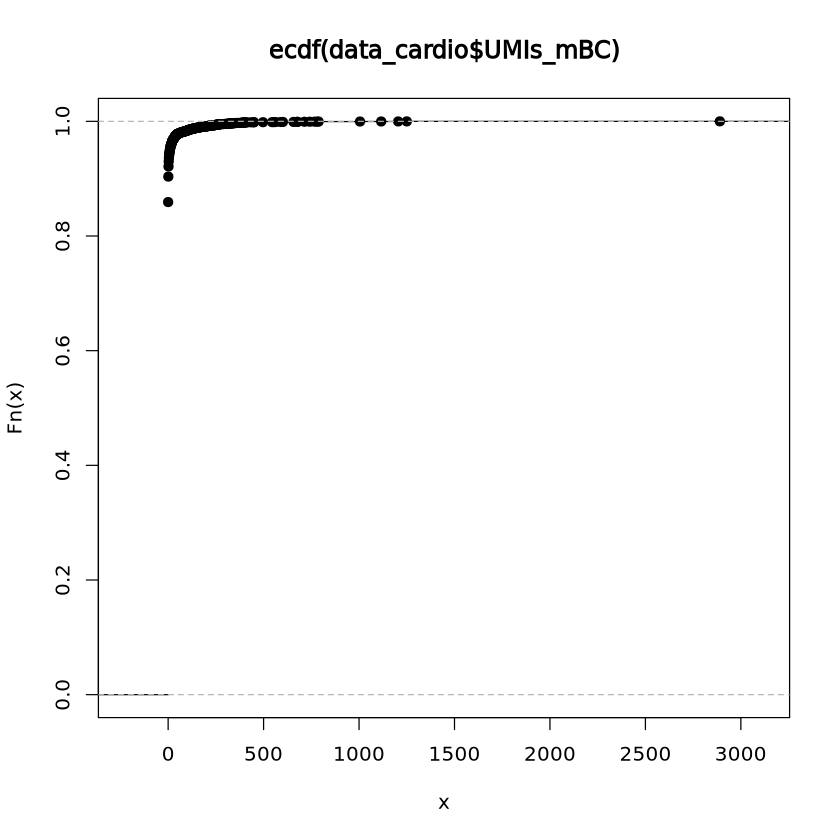

In [10]:
plot(ecdf(data_cardio$UMIs_mBC))

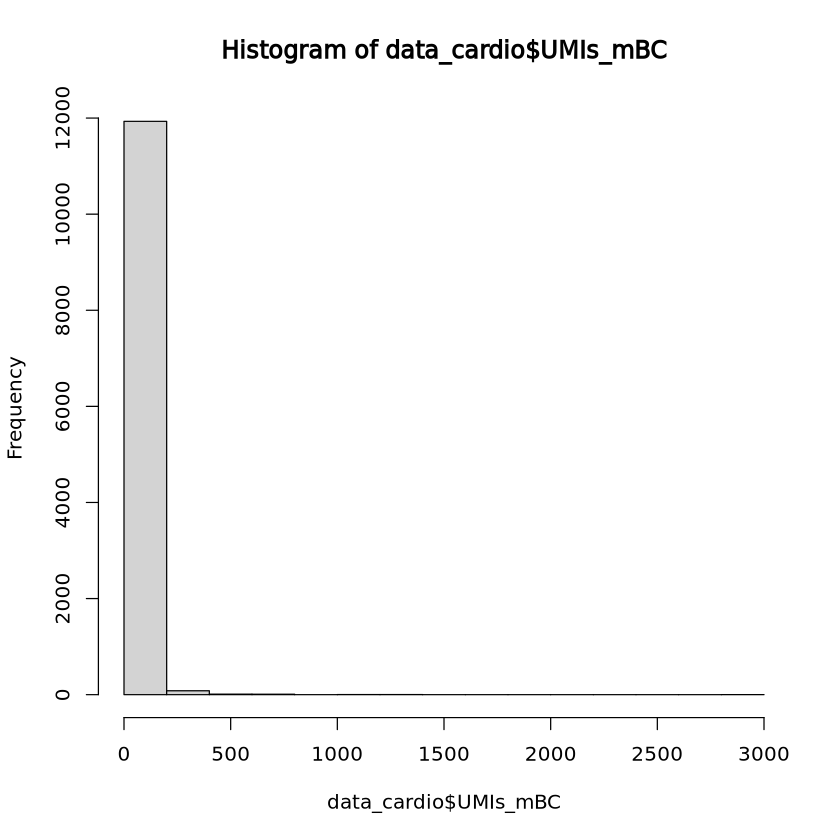

In [11]:
hist(data_cardio$UMIs_mBC)

In [12]:
hist(fitted.values(M4))

ERROR: Error: object 'M4' not found


In [13]:
logLik(M4)

ERROR: Error: object 'M4' not found


In [14]:
r2_zeroinflated(M4)

ERROR: Error: object 'M4' not found


In [17]:
r2_zeroinflated(M4, method="correlation")

R2 for ZI-models 
       0.2560461

In [18]:
model_performance(M4)

AIC      AICc     BIC      R2        R2_adjusted RMSE     Sigma    Score_log
1 16489.66 16498.19 18146.31 0.9981482 0.9981142   42.71805 43.12116 -0.844864
  Score_spherical
1 0.008362709

### Full data

In [39]:
dim(data)

[1] 778248     11

In [40]:
# M5 <- zeroinfl(formula,
#                dist = 'negbin',
#                data = data)
# saveRDS(M5, file = "znb_rep_id_CRE_id_rep_id.RDS")
zinb <- readRDS("znb_rep_id_CRE_id_rep_id.RDS")
summary(zinb)

ERROR: Error: object 'M5' not found


In [ ]:
model_performance(M5)

AIC     AICc    BIC     R2        R2_adjusted RMSE     Sigma    Score_log
1 1121391 1121391 1124085 0.9979999 0.9979994   49.65454 49.66198 -Inf     
  Score_spherical
1 0.001029712

In [ ]:
# Dispersion Statistic
E2 <- resid(M5, type = "pearson")
N  <- nrow(data)
p  <- length(coef(M5)) + 1 # '+1' is due to theta
sum(E2^2) / (N - p)

[1] 3.90578

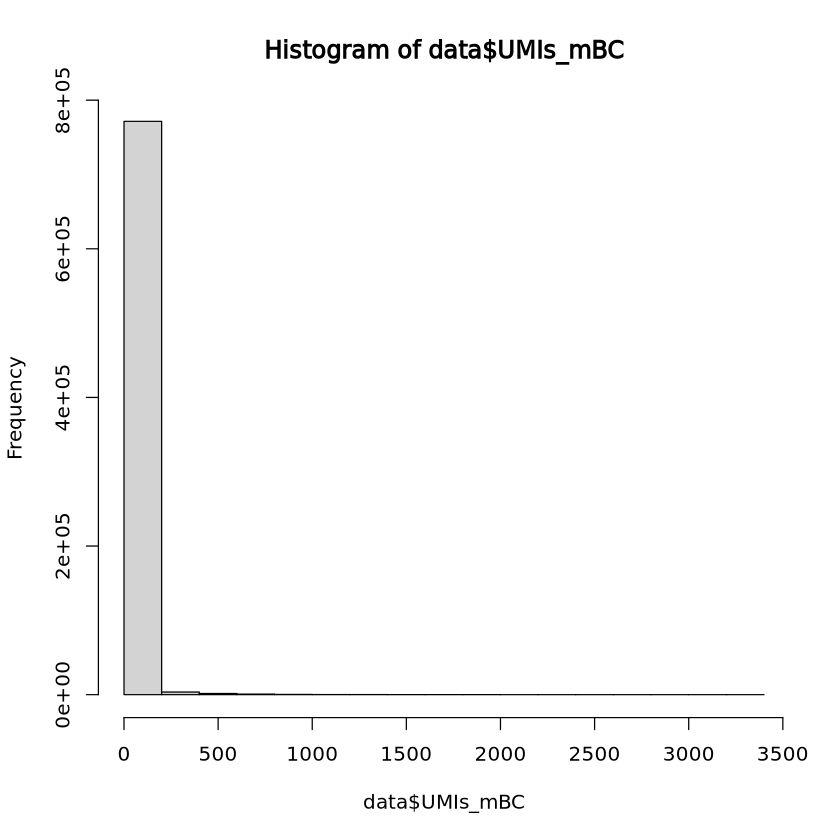

In [ ]:
hist(data$UMIs_mBC)

In [41]:
hist(fitted.values(zinb))

ERROR: Error: object 'M5' not found


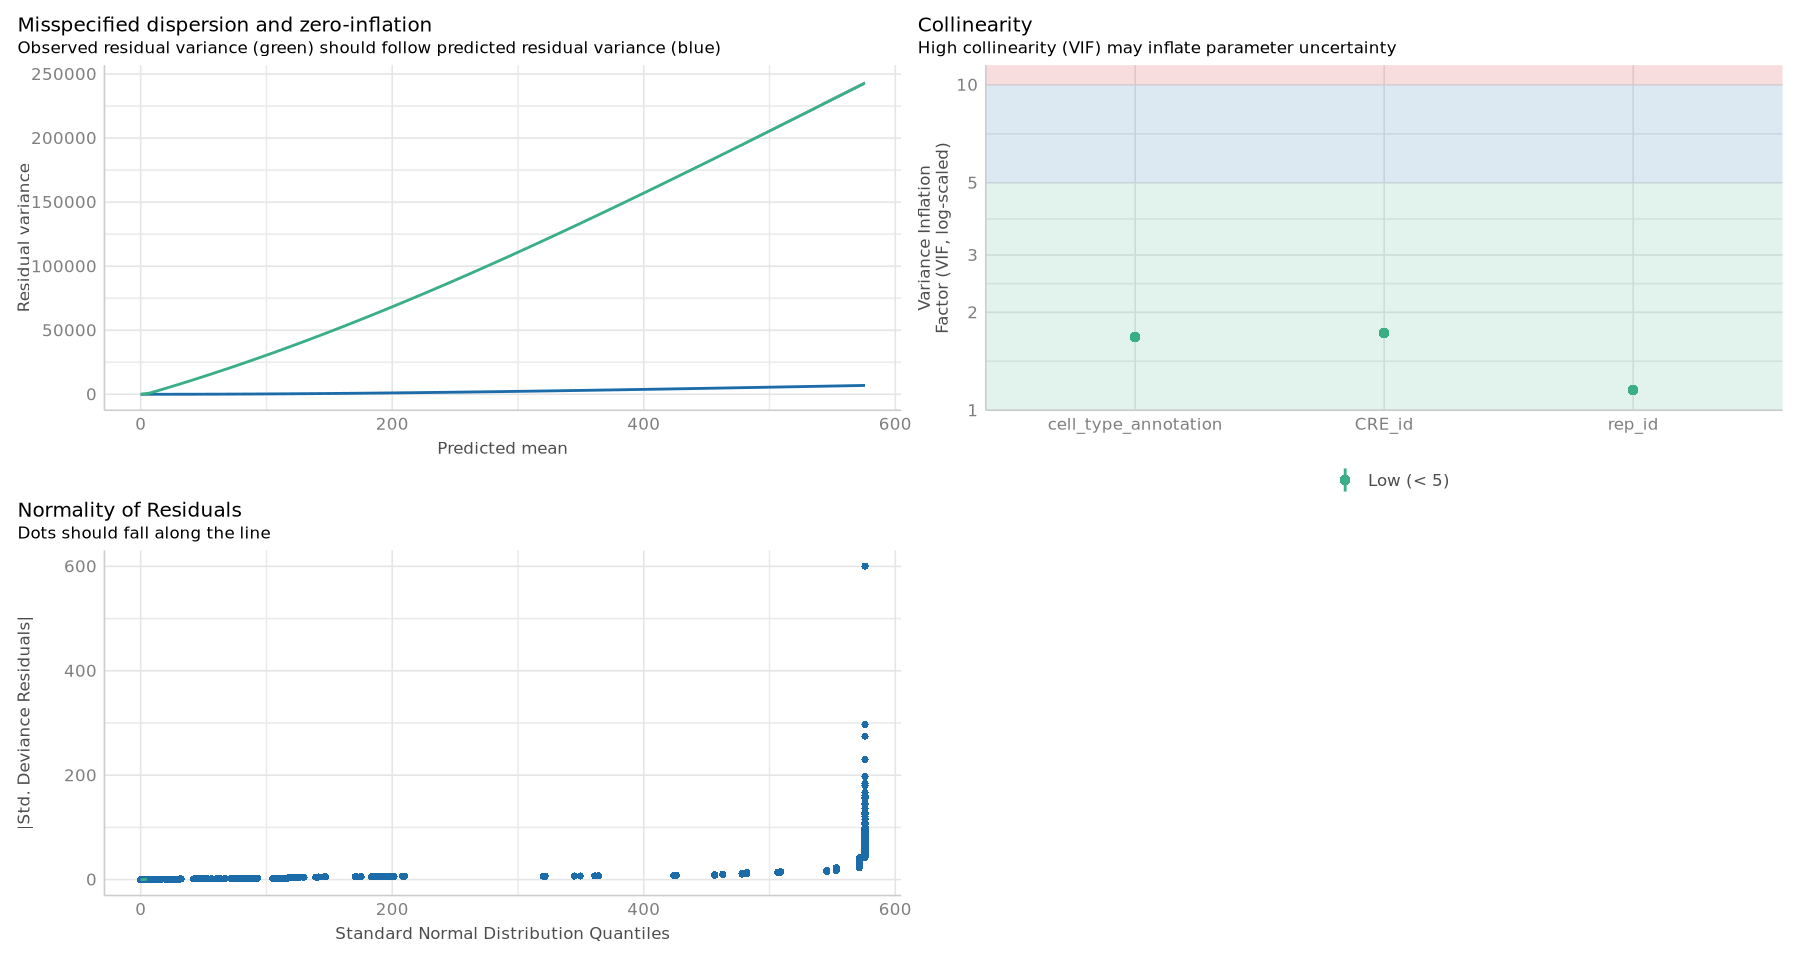

In [30]:
options(repr.plot.width=15, repr.plot.height=8)
check_model(M5, residual_type = "normal")

Using `ci_type = "gaussian"` because model is not bernoulli.

Warning message in sqrt(fitted_values * (1 - fitted_values)):
“NaNs produced”


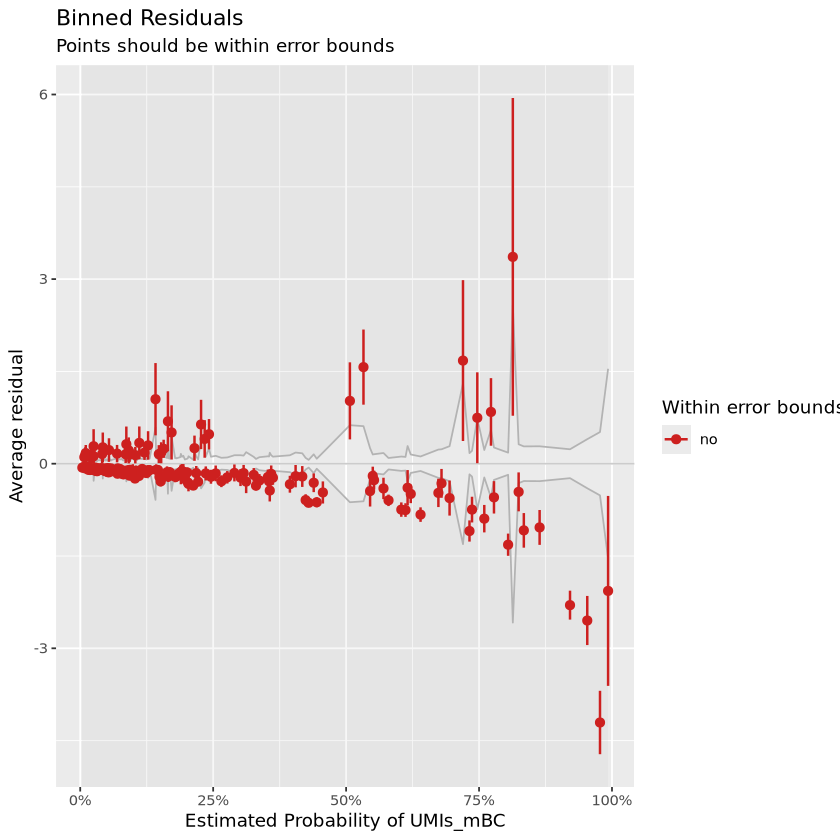

In [23]:
result = binned_residuals(M5, ci_type="boot", residuals="pearson")
plot(result)

# Compare models

In [5]:
pm <- readRDS("poisson_rep_id_CRE_id.RDS")
nb <- readRDS("negbin_rep_id_CRE_id.RDS")
zip <- readRDS("zip_rep_id_CRE_id_rep_id.RDS")
zinb <- readRDS("znb_rep_id_CRE_id_rep_id.RDS")

In [6]:
compare_performance(pm, nb, zip, zinb, rank=T, metrics="all")

Following indices with missing values are not used for ranking: R2,
  R2_adjusted, R2_Nagelkerke



Name Model    RMSE     Sigma    Score_log Score_spherical R2       
1 pm   glm      42.66164  1.00000 -Inf      0.001025918            NA
2 nb   negbin   49.65456  1.00000 -Inf      0.001029712            NA
3 zip  zeroinfl 47.13020 47.13722 -Inf      0.001045348     0.9697754
4 zinb zeroinfl 49.65454 49.66198 -Inf      0.001029712     0.9979999
  R2_adjusted R2_Nagelkerke AIC_wt      AICc_wt     BIC_wt     
1        NA   1.0000000     0.000000000 0.000000000 0.00000e+00
2        NA   0.9083281     0.997529114 0.997537863 1.00000e+00
3 0.9697666          NA     0.000000000 0.000000000 0.00000e+00
4 0.9979994          NA     0.002470886 0.002462137 2.12002e-18
  Performance_Score
1 -Inf             
2 -Inf             
3 -Inf             
4 -Inf

Following indices with missing values are not used for ranking: R2,
  R2_adjusted, R2_Nagelkerke



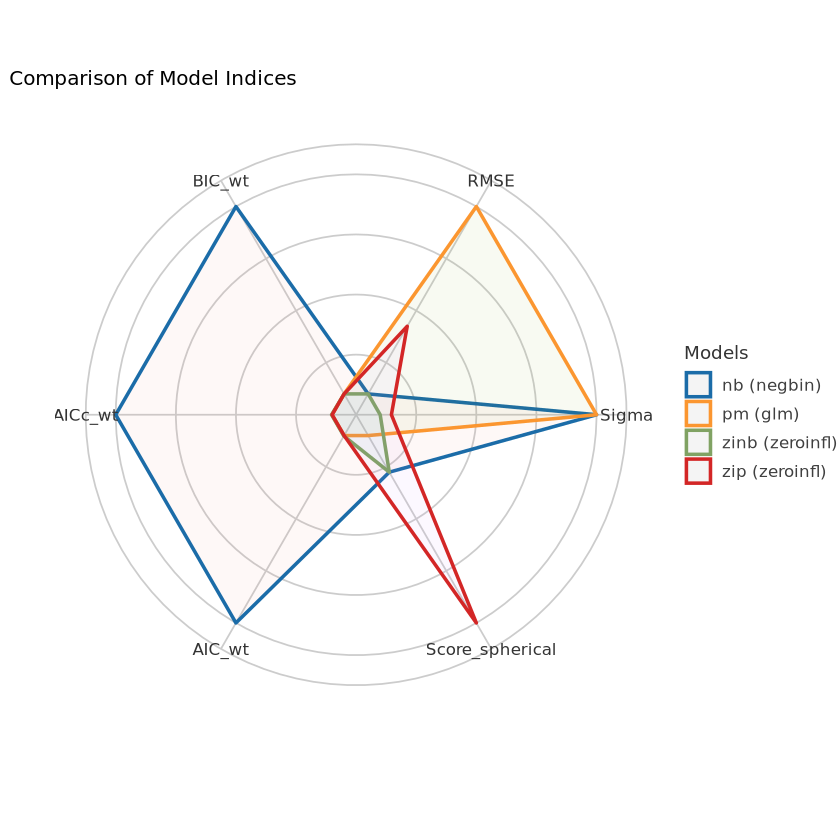

In [7]:
plot(compare_performance(pm, nb, zip, zinb, metrics="all", rank=T))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


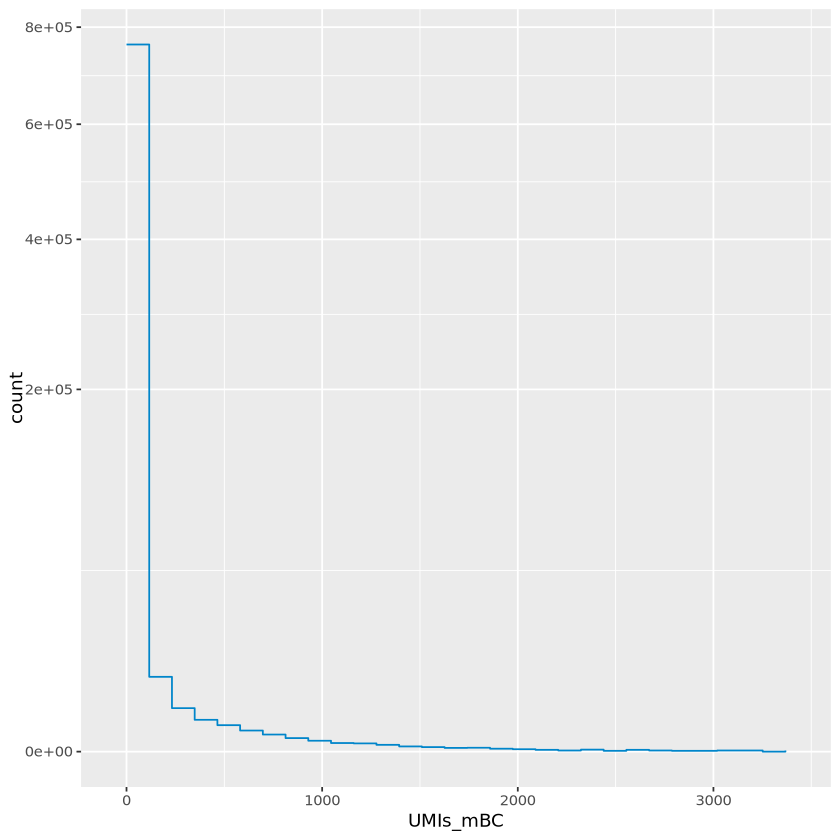

In [30]:
ggplot(data, aes(x=UMIs_mBC), geom='step') + stat_bin(geom='step', color="#0085ca") + scale_y_sqrt()

In [21]:
resid_zeroinfl(zinb, plot=T)

In [22]:
data

cellBC                 rep_id CRE_class CRE_id            
1      2B1_AAACCCACAAGGTTGG-1 2B1    devCRE    Btg1_chr10_9572   
2      2B1_AAACCCACAAGGTTGG-1 2B1    devCRE    Gata4_chr14_5710  
3      2B1_AAACCCACAAGGTTGG-1 2B1    devCRE    Klf4_chr4_3952    
4      2B1_AAACCCACAAGGTTGG-1 2B1    devCRE    Lama1_chr17_7793  
5      2B1_AAACCCACAAGGTTGG-1 2B1    devCRE    Sox17_chr1_67     
6      2B1_AAACCCACAAGGTTGG-1 2B1    devCRE    Sox17_chr1_82     
7      2B1_AAACCCACAAGGTTGG-1 2B1    devCRE    Sparc_chr11_7203  
8      2B1_AAACCCACAAGGTTGG-1 2B1    devCRE    Sparc_chr11_7235  
9      2B1_AAACCCACAAGGTTGG-1 2B1    promoters minP              
10     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Bend5_chr4_8170   
11     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Bend5_chr4_8199   
12     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Bend5_chr4_8201   
13     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Btg1_chr10_9572   
14     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Btg1_chr10_9588   
15     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Btg1_chr10_9613   
16     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Cited2_chr10_1246 
17     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Col5a1_chr2_2558  
18     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Col5a1_chr2_2565  
19     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Col5a1_chr2_2576  
20     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Epas1_chr17_10056 
21     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Epas1_chr17_10066 
22     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Epas1_chr17_10071 
23     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Foxa2_chr2_13808  
24     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Foxa2_chr2_13841  
25     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Foxa2_chr2_13861  
26     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Gata4_chr14_5749  
27     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Gata4_chr14_5752  
28     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Gata4_chr14_5762  
29     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Gata4_chr14_5763  
30     2B1_AAACCCACACGTCGTG-1 2B1    devCRE    Gata4_chr14_5776  
⋮      ⋮                      ⋮      ⋮         ⋮                 
778219 B2_TTTGTTGCAGAGTGTG-1  B2     devCRE    Txndc12_chr4_7961 
778220 B2_TTTGTTGCAGAGTGTG-1  B2     devCRE    Txndc12_chr4_7973 
778221 B2_TTTGTTGCAGAGTGTG-1  B2     devCRE    Txndc12_chr4_7975 
778222 B2_TTTGTTGCAGAGTGTG-1  B2     promoters eef1aP            
778223 B2_TTTGTTGCAGAGTGTG-1  B2     promoters minP              
778224 B2_TTTGTTGCAGAGTGTG-1  B2     promoters noP               
778225 B2_TTTGTTGCAGAGTGTG-1  B2     promoters pgk1P             
778226 B2_TTTGTTGCAGAGTGTG-1  B2     promoters ubcP              
778227 B2_TTTGTTGCATTGAGGG-1  B2     devCRE    Col1a2_chr6_77    
778228 B2_TTTGTTGCATTGAGGG-1  B2     devCRE    Gata4_chr14_5710  
778229 B2_TTTGTTGCATTGAGGG-1  B2     devCRE    Igfbp4_chr11_16738
778230 B2_TTTGTTGCATTGAGGG-1  B2     promoters minP              
778231 B2_TTTGTTGCATTGAGGG-1  B2     promoters ubcP              
778232 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Cdk5r1_chr11_12559
778233 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Col1a1_chr11_15258
778234 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Col1a1_chr11_15259
778235 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Foxa2_chr2_13861  
778236 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Igfbp4_chr11_16710
778237 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Igfbp4_chr11_16738
778238 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Lama1_chr17_7784  
778239 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Lama1_chr17_7874  
778240 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Lamc1_chr1_12185  
778241 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Lamc1_chr1_12193  
778242 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Map1b_chr13_9445  
778243 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Sox17_chr1_59     
778244 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Sparc_chr11_7207  
778245 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Tgfbi_chr13_5735  
778246 B2_TTTGTTGGTGGACCAA-1  B2     devCRE    Tgfbi_chr13_5741  
778247 B2_TTTGTTGGTGGACCAA-1  B2     promoters 

In [23]:
preds = data.frame( rep_id = data$rep_id, 
                    CRE_id = data$CRE_id, 
                    CRE_class = data$CRE_class, 
                    cell_type = data$cell_type_annotation, 
                    umis_obc = data$UMIs_oBC,
                    shendure_umis_mbc = data$UMIs_mBC,
                    zinb=predict(zinb, new_data=data), 
                    nb = predict(nb, new_data=data),
                    pm = predict(pm, new_data=data),
                    zip = predict(zip, new_data=data))

In [24]:
write.csv(preds, "predictions_r_first_round.csv")

In [36]:
residuals(zinb, type='response')

1             2             3             4             5 
-6.904296e-03 -6.891013e-03 -1.851852e-02 -1.038745e-01 -4.913842e-02 
            6             7             8             9            10 
-4.341432e-02 -1.053050e-01  2.465404e+00 -3.337843e-02 -6.903147e-02 
           11            12            13            14            15 
-5.772303e-02 -3.375574e-01 -1.993016e-02 -2.202873e-02 -5.783087e-02 
           16            17            18            19            20 
-3.889739e-02 -2.739868e-02 -3.361452e-02 -7.092558e-02 -3.052748e-02 
           21            22            23            24            25 
-3.634184e-02 -2.953198e-01 -7.689158e-02 -1.101245e-01 -1.775644e-02 
           26            27            28            29            30 
-3.092398e-01 -4.317927e-02 -1.630967e-02 -2.836875e-02 -8.901379e-02 
           31            32            33            34            35 
-4.636990e-01 -2.818200e-01 -5.985236e-02 -1.725471e-01 -5.345614e-02 
           36            37            38            39            40 
-1.905699e-01 -1.083328e+00 -2.483718e-01 -7.650436e-02 -1.188936e-01 
           41            42            43            44            45 
-1.688421e-02  1.773036e+00 -1.078547e+00 -7.178509e-02  3.827315e-01 
           46            47            48            49            50 
-3.031658e-02 -2.271691e-02 -2.946807e-02 -5.697942e-02 -2.912522e-02 
           51            52            53            54            55 
-1.159774e-01 -7.549449e-01 -6.825495e-02 -6.148767e-02 -2.575046e-01 
           56            57            58            59            60 
-1.381074e-01 -3.090421e-02 -8.073410e-01 -3.619258e+02 -9.635126e-02 
           61            62            63            64            65 
-1.296808e-01 -9.287437e+01 -4.495684e+01 -3.776057e-02 -7.907467e-03 
           66            67            68            69            70 
-2.629157e-01 -8.919229e-03 -4.357891e-03  1.384175e+00 -7.589546e-02 
           71            72            73            74            75 
-5.984440e-02 -1.468932e-02 -7.728281e-01 -6.629230e-03 -2.658768e-01 
           76            77            78            79            80 
-1.217969e-02 -1.819720e-02 -2.531380e-02 -4.332126e-02 -2.487252e-03 
           81            82            83            84            85 
-5.575319e-03 -8.835463e-03 -4.120379e-01 -1.509067e-02 -2.364710e-02 
           86            87            88            89            90 
-3.182704e-02 -5.769854e+00 -5.052462e-02 -3.158575e-02 -1.015501e-01 
           91            92            93            94            95 
-6.220529e-03 -7.453199e-02 -3.413022e-02 -5.052462e-02 -2.638894e-02 
           96            97            98            99           100 
-1.058040e-02  8.213476e-01 -2.222090e-02 -5.289343e-03 -7.318922e-03 
          101           102           103           104           105 
-1.103855e-02 -2.329099e-02 -1.002480e-02 -1.193416e-02 -1.376292e-02 
          106           107           108           109           110 
-3.166394e-02 -5.830972e-03 -6.532201e-03 -4.051260e-01 -1.015501e-01 
          111           112           113           114           115 
-5.355872e-03 -9.254584e-02 -1.542618e-02 -9.846576e-02 -3.904303e-02 
          116           117           118           119           120 
-2.120946e-02 -5.699419e-03 -1.088830e-02 -7.896754e-01 -1.007668e-01 
          121           122           123           124           125 
-7.459922e-03 -9.503031e-02 -1.466414e+00 -1.182208e-02 -1.423201e+00 
          126           127           128           129           130 
 1.640649e+01 -3.164043e-02 -2.749867e+01 -5.052462e-02 -1.108492e-01 
          131           132           133           134           135 
-3.226475e-02 -6.626622e-01 -2.638894e-02 -6.122873e-03 -1.058040e-02 
          136           137           138           139           140 
-7.847303e-02 -2.070058e-02 -3.517881e-01 -1.707004e-02 -5.289343e-03 
          141           142         

In [33]:
length(a)

[1] 778248

In [34]:
a

1             2             3             4             5 
-8.190928e-02 -8.183268e-02 -1.310657e-01 -2.687992e-01 -2.017675e-01 
            6             7             8             9            10 
-1.915754e-01 -2.700782e-01  7.283800e-01 -1.710647e-01 -2.312524e-01 
           11            12            13            14            15 
-2.154785e-01 -3.733084e-01 -1.355959e-01 -1.419783e-01 -2.156402e-01 
           16            17            18            19            20 
-1.828123e-01 -1.567264e-01 -1.715938e-01 -2.336823e-01 -1.644643e-01 
           21            22            23            24            25 
-1.775279e-01 -3.627523e-01 -2.409914e-01 -2.742674e-01 -1.285321e-01 
           26            27            28            29            30 
-3.664459e-01 -1.911361e-01 -1.235354e-01 -1.591854e-01 -2.544318e-01 
           31            32            33            34            35 
-3.962201e-01 -3.589419e-01 -2.186294e-01 -3.160893e-01 -2.088772e-01 
           36            37            38            39            40 
-3.251166e-01 -4.412388e-01 -3.483778e-01 -2.405320e-01 -2.814488e-01 
           41            42            43            44            45 
-1.255503e-01  2.660883e+00 -4.410632e-01 -2.347669e-01  2.567222e-01 
           46            47            48            49            50 
-1.639598e-01 -1.439881e-01 -1.619058e-01 -2.143563e-01 -1.610648e-01 
           51            52            53            54            55 
-2.791204e-01 -4.249420e-01 -2.302400e-01 -2.209888e-01 -3.514364e-01 
           56            57            58            59            60 
-2.954756e-01 -1.653598e-01 -2.046045e-01 -4.843472e-01 -2.617843e-01 
           61            62            63            64            65 
-2.895877e-01 -4.865612e-01 -4.555802e-01 -1.804928e-01 -8.747865e-02 
           66            67            68            69            70 
-3.531840e-01 -9.271566e-02 -6.541651e-02  9.303271e-01 -2.398056e-01 
           71            72            73            74            75 
-2.186178e-01 -1.176146e-01 -4.261229e-01 -8.030631e-02 -3.541208e-01 
           76            77            78            79            80 
-1.076345e-01 -1.300053e-01 -1.512422e-01 -1.914017e-01 -4.961307e-02 
           81            82            83            84            85 
-7.380623e-02 -9.229495e-02 -3.880693e-01 -1.191157e-01 -1.466444e-01 
           86            87            88            89            90 
-1.675226e-01 -2.364558e-01 -2.041004e-01 -1.669612e-01 -2.666847e-01 
           91            92            93            94            95 
-7.785667e-02 -2.381607e-01 -1.727407e-01 -2.041004e-01 -1.541055e-01 
           96            97            98            99           100 
-1.006423e-01  1.467804e+00 -1.425434e-01 -7.193078e-02 -8.426140e-02 
          101           102           103           104           105 
-1.027034e-01 -1.456354e-01 -9.807419e-02 -1.065965e-01 -1.140552e-01 
          106           107           108           109           110 
-1.671435e-01 -7.543975e-02 -7.973229e-02 -3.868649e-01 -2.666847e-01 
          111           112           113           114           115 
-7.237182e-02 -2.580381e-01 -1.203526e-01 -2.638067e-01 -1.831059e-01 
          116           117           118           119           120 
-1.395337e-01 -7.460407e-02 -1.020329e-01 -4.271949e-01 -2.659617e-01 
          121           122           123           124           125 
-8.504468e-02 -2.604997e-01 -4.519763e-01 -1.061187e-01 -4.510234e-01 
          126           127           128           129           130 
 1.138237e+01 -1.670887e-01 -4.375615e-01 -2.041004e-01 -2.748819e-01 
          131           132           133           134           135 
-1.685336e-01 -4.180366e-01 -1.541055e-01 -7.725861e-02 -1.006423e-01 
          136           137           138           139           140 
-2.428467e-01 -1.379854e-01 -3.764652e-01 -1.261932e-01 -7.193078e-02 
          141           142         